### Covariance analyses on Pratt's sensilla STA data
The STA were calculated in response to gaussian white noise.

In [1]:
import os
import os.path as path

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA

from src.data.load_dataset import load_sensilla_sta
from src.models.weights import sensilla_covariance_matrix, sensilla_weights

data_dir = path.abspath(path.join(os.getcwd(), "../../"))

#### Load the STA data and plot

/Users/kronos/projects/random_features/data/processed/


Text(0, 0.5, 'Amplitude')

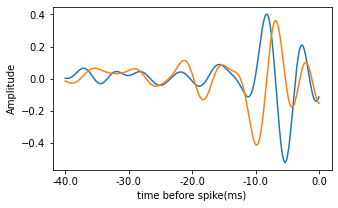

In [2]:
sta, samp_rate, samp_window = load_sensilla_sta()
num_cells, dim = sta.shape

np.random.seed(20)
fig = plt.figure(figsize=(5, 3))
for i in range(2):
    idx = np.random.randint(len(sta))
    plt.plot(sta[idx])
plt.xticks(np.linspace(0, 1600, 5), labels=np.linspace(-40, 0, 5))
plt.xlabel('time before spike(ms)')
plt.ylabel('Amplitude')

#### Compute covariance from data and fit optimal hyperparameters

In [3]:
# compute data covariance
cov_data = sta.T @ sta
cov_data *= cov_data.shape[1] / np.trace(cov_data)

def sensilla_covariance_matrix_to_minimize(N, lowcut, highcut, decay_coef, scale=1): 
    ''' Changed to a linear programming problem so that it can be minimized easily.
    Find lowcut and highcut real numbers and divide into equally spaced intervals.
    The number of intervals equals to their difference'''
    
    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    t = int(np.round(highcut - lowcut)) # number of intervals
    C_cos = np.zeros((N, N))
    for j in np.linspace(lowcut, highcut, t): # divide into number of intervals
        C_cos += np.cos(2 * np.pi * j * diff / N)

    # exponential part
    C_exp = np.exp(((xx - N) + (yy - N)) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = sensilla_covariance_matrix_to_minimize(dim, lowcut=x[0], highcut=x[1], decay_coef=x[2], scale=1)
    return la.norm(cov_model - cov_data)

x0 = [3, 8, 20]
cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0]})
min_diff = minimize(frob_norm_diff, x0, method='trust-constr', constraints=cons, tol=1e-4)
lowcut_min, highcut_min, decay_coef_min = min_diff.x
print("Optimal params: lowcut=%0.3f, highcut=%0.3f, decay_coef=%0.3f" %(lowcut_min, highcut_min, decay_coef_min))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimal params: lowcut=3.050, highcut=8.277, decay_coef=22.069


#### Generate covariance matrices for data and model

(-0.5, 1599.5, 1599.5, -0.5)

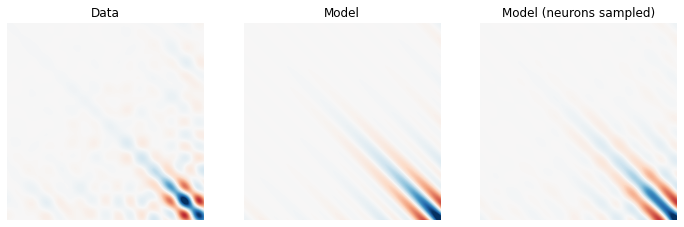

In [4]:
lowcut, highcut, decay_coef, scale = int(np.round(lowcut_min)), int(np.round(highcut_min)), decay_coef_min.copy(), 1

# model
cov_model = sensilla_covariance_matrix(dim, lowcut, highcut, decay_coef, scale=scale)

# cov from sampled neurons
W = sensilla_weights(num_cells, dim, lowcut, highcut, decay_coef, scale=scale)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_sampled_neurons.shape[0] / np.trace(cov_sampled_neurons)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')

ax = fig.add_subplot(133)
plt.title('Model (neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-5, 5)
plt.axis('off')

#### Plot some STAs

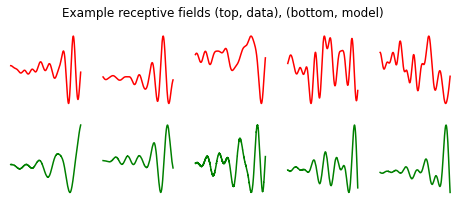

In [5]:
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.plot(sta[idx], 'r')
    plt.axis('off')
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.plot(W[idx], 'g')
    plt.axis('off')
# plt.savefig('reports/figures/sta_Pratt_sensilla.pdf')

#### Compute eigenvalues and eigenvectors

In [6]:
# generate eigenfunctions and eigenvalues from the covariance matrices
eval_data, evec_data = la.eigh(cov_data)
eval_model, evec_model = la.eigh(cov_model)
eval_sampled_neurons, evec_sampled_neurons = la.eigh(cov_sampled_neurons)

#### Plot eigenvalues from all 3 (data, model, sampled neurons)

Data: 10 evecs explain 0.97 variance
Model: 10 evecs explain 1.00 variance
Sampled neurons: 10 evecs explain 1.00 variance


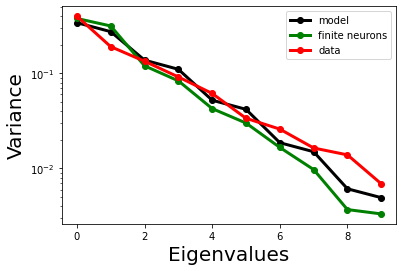

In [7]:
# eigevalues
eval_data /= np.sum(eval_data)
eval_model /= np.sum(eval_model)
eval_sampled_neurons /= np.sum(eval_sampled_neurons)

t = 10
fig = plt.figure()
plt.semilogy(np.flip(eval_model)[:t], 'k-o', lw=3, label='model')
plt.semilogy(np.flip(eval_sampled_neurons)[:t], 'g-o', lw=3, label='finite neurons')
plt.semilogy(np.flip(eval_data)[:t], 'r-o', lw=3, label='data')
plt.legend()
# plt.ylim(1e-4, 1e-1)
# plt.xlim(-0.5, 30)
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))
print('Model: %d evecs explain %0.2f variance' % (t, np.sum(eval_model[-t:])))
print('Sampled neurons: %d evecs explain %0.2f variance' % (t, np.sum(eval_sampled_neurons[-t:])))
# plt.savefig('reports/figures/cov_mat_eigvals_Pratt_sensilla.pdf')

#### Plot eigenfunctions from all 4 (data, model, sampled neurons, analytical)

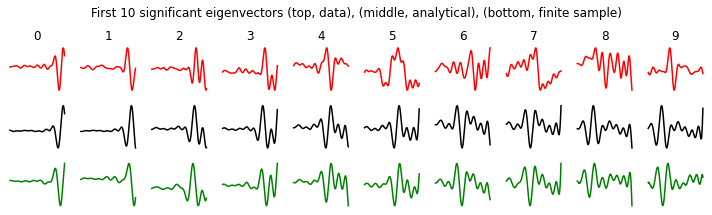

In [8]:
fig = plt.figure(figsize=(10, 3))
plt.suptitle('First 10 significant eigenvectors (top, data), (middle, analytical), (bottom, finite sample)')
for i in range(10):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(i)
    plt.plot(evec_data[:, -i - 1], c='r')
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 10 + i +1)
    plt.plot(evec_model[:, -i - 1] * -1, c='k')
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 20 + i +1)
    plt.plot(evec_sampled_neurons[:, -i - 1] * -1, c='g')
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.8)
# plt.savefig('reports/figures/cov_mat_eigvecs_Pratt_sensilla.pdf')

### Use normality tests to check whether the data is normal

In [9]:
# whiten the dataset
sta = (sta - np.mean(sta, axis=0)) / np.std(sta, axis=0)
pca = PCA(whiten=True)
sta = pca.fit_transform(sta)

# perform the WS test
ws, pval = stats.shapiro(sta)
normal = True if pval > 0.05 else False 
print('Wilkes-Shapiro test: ws statistic: {:.2f}, p-value {:.2f}. Data is normal? {}'.format(ws, pval, normal))

Wilkes-Shapiro test: ws statistic: 0.98, p-value 0.00. Data is normal? False


/opt/anaconda3/envs/random_features/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
